# Nerual Networks
The goal of the homework is to achieve higher accuracy with neural networks in comparison to KNN. I take the same document embeddings (concatenated vector of maximum and average vectors).

In [56]:
import torch
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.autograd import Variable
from torch.utils.data import DataLoader


pd.set_option('display.max_colwidth', 300)

np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)

%matplotlib inline
pd.set_option('display.max_colwidth', 300)
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##  Data: small dataset - 200 documents, 8 classes

In [15]:
small_dataset = 'proc_data_initial_small.pkl'
df = pd.read_pickle(small_dataset)
df.groupby('category').count()

,text,lang,doc2vec,doc2vec_reshape
category,,,,
Відсутність-ГВП,75,75,75,75
Відсутність-опалення,44,44,44,44
Перевірка-дозвільної-документації--демонтаж-кіосків--ларків,67,67,67,67
Прибирання-та-санітарний-стан-територій,35,35,35,35
Проблемні-питання-житлового-масиву-Нивки,57,57,57,57
Ремонт-під-їзду-,37,37,37,37
Технічний-стан-проїжджих-частин-вулиць-та-тротуарів,162,162,162,162
Укладання-та-ремонт-асфальтного-покриття,99,99,99,99


## Data: bigger dataset - 10731 documents, 14 classes

In [5]:
bigger_dataset = 'proc_data_short.pkl'
df = pd.read_pickle(bigger_dataset)
df.groupby('category').count()

,text,lang,doc2vec,doc2vec_reshape
category,,,,
Інші-технічні-недоліки-стану-ліфту,866,866,866,866
Будівництво-дооблаштування-дитячого-майданчику,745,745,745,745
Встановлення-та-експлуатація-лічильників-на-водопостачання,689,689,689,689
Відсутнє-ХВП,808,808,808,808
Відсутність-освітлення-на-опорних-стовпах-за-відсутності-несправності-лампочок,583,583,583,583
ГЛ--Несанкціонована-торгівля-,1013,1013,1013,1013
Незадовільна-температура-опалення,713,713,713,713
Освітлення-в-приміщенні-й-при-вході-в-нього,785,785,785,785
Перевірка-наявності-дозволів-на-виконання-будівельних-робіт,852,852,852,852


## Data: whole dataset - 89321 documents, 188 classes

In [7]:
whole_dataset = 'proc_data_long_new.pkl'
df = pd.read_pickle(whole_dataset)
df.groupby('category').count()

,text,lang,doc2vec,doc2vec_reshape
category,,,,
Інші-Подяки,369,369,369,369
Інші-технічні-недоліки-стану-ліфту,812,812,812,812
Аварійний--травмонебезпечний-стан-утримання-об-єктів-благоустрою,308,308,308,308
Бажаючі-отримати--Картки-киянина--КК--,75,75,75,75
Будівництво--дооблаштування-спортивних-майданчиків,119,119,119,119
Будівництво-АЗС,80,80,80,80
Будівництво-в-нічний-час,62,62,62,62
Будівництво-дооблаштування-дитячого-майданчику,700,700,700,700
Будівництво-та-реконструкція-об-єктів-освіти,165,165,165,165


In [59]:
def add_category_ids(df_inp):
    df = df_inp.copy()
    categories_list = dict(enumerate(df['category'].unique()))
    categories = {name: num for num, name in categories_list.items()}
    df.loc[:,'category_id'] = df['category'].map(lambda name: categories.get(name))
    return df

def read_split(df_file):
    df = pd.read_pickle(df_file)
    
    df = add_category_ids(df)
    
    X = df['doc2vec_reshape'].tolist()

    y = df['category_id'].tolist()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test

def loader(X_train, X_test, y_train, y_test, batch_size=128):
    trainset = [(a, b) for a, b in zip(X_train, y_train)]
    testset = [(a, b) for a, b in zip(X_test, y_test)]
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)
    
    return trainloader, testloader

# X_train, X_test, y_train, y_test = read_split(small_dataset)
X_train, X_test, y_train, y_test = read_split(bigger_dataset)
# X_train, X_test, y_train, y_test = read_split(whole_dataset)

trainloader, testloader = loader(X_train, X_test, y_train, y_test, batch_size=1000)

## Feed Forward Neural Network

In [60]:
class FeedForwardNN(nn.Module):
    def __init__(self, classes, require_bias=True):
        super(FeedForwardNN, self).__init__()
        self.linear1 = nn.Linear(in_features=600, out_features=200)
        self.relu = nn.ReLU(inplace=False)
        self.linear2 = nn.Linear(in_features=200, out_features=classes)
        
    def forward(self, inp_batch):
        out = self.linear1(inp_batch)
        out = self.relu(out) #in_features=inp_batch, out_features=1, bias=require_bias)
        out = self.linear2(out)
        
        # Softmax layer
        tag_scores = F.log_softmax(out, dim=1)
        return tag_scores

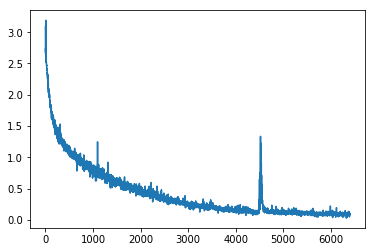

In [62]:
model = FeedForwardNN(classes=len(set(y_train)))
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
losses_visualize = []

model = model.to(device)
loss_fn = loss_fn.to(device)

model.train()
    
for epoch in range(800):
    for batch_i, batch in enumerate(trainloader):

        optim.zero_grad()
        X_in, y_in = batch
        X_in = X_in.to(device)
        y_in = y_in.to(device)

        out = model(X_in)
        loss = loss_fn(out, y_in.long())
        losses_visualize.append(loss.item())

        loss.backward()
        optim.step()

plt.plot(losses_visualize)

In [63]:
model.cuda()

FeedForwardNN(
  (linear1): Linear(in_features=600, out_features=200, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=200, out_features=14, bias=True)
)

### Test

In [64]:
X_te = Variable(torch.FloatTensor(X_test), requires_grad=False).to(device)
y_te = Variable(torch.FloatTensor(y_test), requires_grad=False).to(device)

def print_evaluation(model, y_labels):
    valid_loss = []
    model.eval()
    output = model(X_te)
    loss = loss_fn(output, y_te.long())
    valid_loss.append(loss.item())
    
    predicted = torch.argmax(output, 1)
    labels = y_labels.long()
    correct = (predicted == labels).sum().to(dtype=torch.float) 
    accuracy = (correct/ len(y_te))
    accuracy = accuracy.data.cpu().numpy().tolist()
    
    print('Validation loss:', valid_loss)
    print('Accuracy:', accuracy)
    
    print(classification_report(predicted.cpu(), labels.cpu()))
    
    return valid_loss, accuracy

valid_loss, accuracy = print_evaluation(model, y_te)

Validation loss: [3.783625602722168]
Accuracy: 0.5773574113845825
              precision    recall  f1-score   support

           0       0.52      0.62      0.57       244
           1       0.47      0.44      0.45       195
           2       0.66      0.65      0.65       285
           3       0.63      0.67      0.65       284
           4       0.50      0.51      0.51       175
           5       0.57      0.66      0.61       206
           6       0.38      0.38      0.38       258
           7       0.61      0.73      0.66       240
           8       0.65      0.44      0.52       377
           9       0.54      0.54      0.54       217
          10       0.60      0.57      0.58       276
          11       0.78      0.74      0.76       267
          12       0.18      0.23      0.21       173
          13       0.78      0.76      0.77       345

   micro avg       0.58      0.58      0.58      3542
   macro avg       0.56      0.57      0.56      3542
weighted avg  

## LSTM
Doc Embedding -> LSTM -> Dropout -> FC.

In [65]:
# Defining Model
class DocumentLSTM(nn.Module):
    def __init__(self, classes):
        super(DocumentLSTM, self).__init__()
        
        self.rnn = nn.LSTM(input_size=600, hidden_size=100, num_layers=1, dropout=0.5,
                        batch_first=True, bidirectional=False)
                 
        self.fc = nn.Linear(100, classes)
        
    def forward(self, inp_batch):
        
        inputs = inp_batch.view(len(inp_batch), 1, -1)

        output, (final_hidden_state, final_cell_state) = self.rnn(inputs, None)
        
        out = self.fc(final_hidden_state[-1])
        
        return out

/olhasempienv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


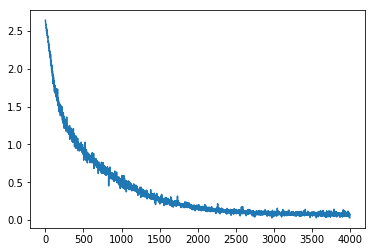

In [67]:
modelLSTM = DocumentLSTM(classes=len(set(y_train)))
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(modelLSTM.parameters())
losses_visualize = []

modelLSTM = modelLSTM.to(device)
loss_fn = loss_fn.to(device)

modelLSTM.train()

for epoch in range(500):
    for batch_i, batch in enumerate(trainloader):
        
        X_in, y_in = batch
        X_in = X_in.to(device)
        y_in = y_in.to(device)

        optim.zero_grad()

        out = modelLSTM(X_in)
        loss = loss_fn(out, y_in.long())
        losses_visualize.append(loss.item())

        loss.backward()
        optim.step()

plt.plot(losses_visualize)

In [68]:
modelLSTM.cuda()

DocumentLSTM(
  (rnn): LSTM(600, 100, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=100, out_features=14, bias=True)
)

In [69]:
valid_loss, accuracy = print_evaluation(modelLSTM, y_te)

Validation loss: [1.9100836515426636]
Accuracy: 0.5951439738273621
              precision    recall  f1-score   support

           0       0.61      0.58      0.60       306
           1       0.41      0.44      0.42       166
           2       0.69      0.60      0.64       319
           3       0.66      0.68      0.67       291
           4       0.54      0.56      0.55       170
           5       0.58      0.68      0.63       203
           6       0.37      0.44      0.40       215
           7       0.67      0.72      0.69       265
           8       0.63      0.65      0.64       245
           9       0.54      0.53      0.53       220
          10       0.65      0.46      0.54       367
          11       0.77      0.77      0.77       254
          12       0.19      0.24      0.21       171
          13       0.80      0.77      0.78       350

   micro avg       0.60      0.60      0.60      3542
   macro avg       0.58      0.58      0.58      3542
weighted avg 

## Results
### Small dataset - 385 documents, 8 classes
KNN -> FFN<br>
f1-score micro avg: 0.60 -> 0.68<br>
f1-score macro avg: 0.58 -> 0.66<br>

KNN -> LSTM (BiLSTM with dropout)<br>
f1-score micro avg: 0.60 -> 0.69 <br>
f1-score macro avg: 0.58 -> 0.68<br>

### Bigger dataset - 3542 documents, 14 classes
KNN -> FNN<br>
f1-score micro avg: 0.33 -> 0.58<br>
f1-score macro avg: 0.32 -> 0.56<br>

KNN -> LSTM (BiLSTM with dropout)<br>
f1-score micro avg: 0.33 -> 0.60<br>
f1-score macro avg: 0.32 -> 0.58<br>


Neural Networks performs way better than KNN for this problem.